In [1]:
import h5py
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
import os

def datx2py(file_name):
    """Loads a .datx into Python, credit goes to gkaplan.
    https://gist.github.com/g-s-k/ccffb1e84df065a690e554f4b40cfd3a"""
    def _group2dict(obj):
        return {k: _decode_h5(v) for k, v in zip(obj.keys(), obj.values())}
    def _struct2dict(obj):
        names = obj.dtype.names
        return [dict(zip(names, _decode_h5(record))) for record in obj]
    def _decode_h5(obj):
        if isinstance(obj, h5py.Group):
            d = _group2dict(obj)
            if len(obj.attrs):
                d['attrs'] = _decode_h5(obj.attrs)
            return d
        elif isinstance(obj, h5py.AttributeManager):
            return _group2dict(obj)
        elif isinstance(obj, h5py.Dataset):
            d = {'attrs': _decode_h5(obj.attrs)}
            try:
                d['vals'] = obj[()]
            except (OSError, TypeError):
                pass
            return d
        elif isinstance(obj, np.ndarray):
            if np.issubdtype(obj.dtype, np.number) and obj.shape == (1,):
                return obj[0]
            elif obj.dtype == 'object':
                return _decode_h5([_decode_h5(o) for o in obj])
            elif np.issubdtype(obj.dtype, np.void):
                return _decode_h5(_struct2dict(obj))
            else:
                return obj
        elif isinstance(obj, np.void):
            return _decode_h5([_decode_h5(o) for o in obj])
        elif isinstance(obj, bytes):
            return obj.decode()
        elif isinstance(obj, list) or isinstance(obj, tuple):
            if len(obj) == 1:
                return obj[0]
            else:
                return obj
        else:
            return obj
    with h5py.File(file_name, 'r') as f:
        h5data = _decode_h5(f)
    return h5data

def get_data(datx_file):
    """Returns the Surface and Intensity data from a single .datx file"""
    myh5 = datx2py(datx_file)                      # File is the string with the location of the file
    zsurf = myh5['Data']['Surface']           # Get the surfaces
    zdata = list(zsurf.values())[0]           # Good for fixing stuff later  
    zsurf = zdata['vals']                     # Get the data from the surface group
    zsurf[zsurf == zdata['attrs']['No Data']] = np.nan  # Write no data as NaNs for compatibility
    zint = myh5['Data']['Intensity']          # Get the intensity group
    zint = list(zint.values())[0]['vals'].astype(float)  # Get the data from the intensity grou[]
    zint[zint>200000] = np.nan                # This fixes the regions left out from stitching
    return zsurf, zint
    
def getcleansurf(img):
    suma = np.nansum(img, axis=0)
    counts = np.sum(~np.isnan(img), axis=0)
    counts[counts<20] = 0
    f = suma/counts
    f[np.isinf(f)] = np.nan
    return f

def find_edge(y, v):
    g2 = np.abs(np.gradient(y))
    idx = np.argwhere(g2>v)
    l = idx[0][0]
    h = idx[-1][0]
    return l,h

def subline(f, offx, offy):
    xchange = -len(f)
    ychange = (f[0]-offx)-(f[-1]-offy)
    xarray = np.arange(len(f))
    yarray = xarray*(ychange/xchange) + (f[0]-offx)
    res = (f-yarray)
    return res

def plot_bounds(i, C, l):
    plt.figure(figsize=(7, 5))
    plt.subplot(211)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.subplot(223)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.xlim(C[i,0]-l, C[i,0]+l)
    plt.subplot(224)
    plt.plot(first_pass[i])
    plt.axvline(C[i,0], color="black", linestyle="dashed")
    plt.axvline(C[i,1], color="black", linestyle="dashed")
    plt.xlim(C[i,1]-l, C[i,1]+l)
    plt.tight_layout()
    
def plotrel_profile(i, C, o):
    plt.figure(figsize=(14, 5))
    s_past = subline(first_pass[i-1][C[i-1,0]:C[i-1,1]]/1e3, o[i-1,0], o[i-1,1])
    s_curr = subline(first_pass[i][C[i,0]:C[i,1]]/1e3, o[i,0], o[i,1])
    s_futu = subline(first_pass[i+1][C[i+1,0]:C[i+1,1]]/1e3, o[i+1,0], o[i+1,1])

    plt.plot(s_past, label="Past")
    plt.plot(s_curr, label="Current")
    plt.plot(s_futu, label="Future")
    plt.axhline(np.nanmax(s_curr), color="black", linestyle="--")
    plt.axhline(0, color="black", linestyle="--")
    plt.legend()

def shift(n_s, f):
    start[n_s:] += f*np.arange(n-n_s)

In [3]:
# Load TIMELAPSE files and get times

folder = "/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/additional_data/Long growth/2022-04-15_longtime/"
files = glob(folder+"Raw/*.datx")                                           # Folder with all the .datx
files.sort()
files_split = [files[0:21], files[21:42], files[42:63]]     
tstart = 1650073000.0
times = np.zeros([3, 21])
n = 21   
C = np.zeros([21, 2]) 
offsets = np.zeros([21,2])
for i in range(3):
    for j in range(21):
        times[i,j] = (os.path.getmtime(files_split[i][j])-tstart)/3600
print(times)
np.save(folder+"Clean/times.npy", times)


[[ 41.24444444  41.28944444  41.33722222  85.21277778  85.27
   85.38833333 133.05388889 133.12833333 133.20722222 184.11777778
  184.18888889 184.26722222 229.25888889 229.35222222 229.45
  277.22722222 277.32722222 277.44111111 324.81666667 324.95166667
  325.05833333]
 [ 41.57277778  41.61111111  41.66722222  85.84444444  85.93888889
   86.03888889 133.66277778 133.79666667 133.94333333 184.71222222
  184.86666667 185.02555556 229.93444444 230.10388889 230.27444444
  277.87222222 278.03111111 278.32444444 325.96333333 326.305
  326.70777778]
 [ 41.40722222  41.45166667  41.49055556  85.47777778  85.61166667
   85.67111111 133.34944444 133.40555556 133.465      184.38166667
  184.45833333 184.53       229.57       229.64722222 229.71888889
  277.55666667 277.63       277.70277778 325.21055556 325.32833333
  325.43      ]]


## 1. Biofilm edges

In this step we find the left `l` and right `r` edges in the biofilm profile, we use the function `find_edge(profile)`, which will automatically find them for us. Since experimental data is subject to the Zygo stitching algorithm, the algorithm *may* fail, adjusting the edge location **should** be done before the other steps. 
`l` and `r` and then stored in an Array containing all the edge locations `C`.
For this we first lower the dimensionality of all the timelapse `j` into a list of profiles called `first_pass`. That way when we call them individually and plot against each other they are ready to plot.

Then, we loop over the indivdual profiles `i` while also plotting the previous `i-1` and future `i+1` timesteps. We start from a base offset of 0, that should output the relative height of the profiles in relation to the 

In [169]:
# Load the timelapse here with j
first_pass = []
j = 2                                     # Which of the replicates we'll be working on
for i in range(n):
    s = getcleansurf(get_data(files_split[j][i])[0])# Load profiles as a 1-D array
    first_pass.append(s)
    lim_edge = 50
    l, r = find_edge(s,lim_edge)                      # Here, 15 is the detection threshold
    C[i] = np.array([l,r])
    print(i, end="\r")

/tmp/ipykernel_9136/2109317321.py:70: RuntimeWarning: divide by zero encountered in true_divide
  f = suma/counts
/tmp/ipykernel_9136/2109317321.py:70: RuntimeWarning: invalid value encountered in true_divide
  f = suma/counts


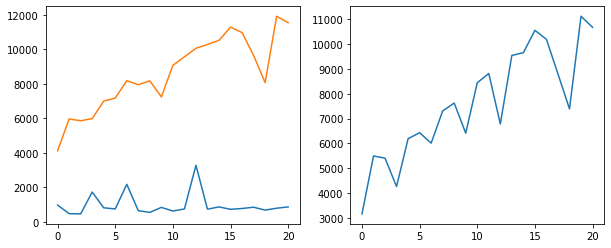

In [124]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(C[:,:])
plt.subplot(122)
plt.plot(C[:,1]-C[:,0])

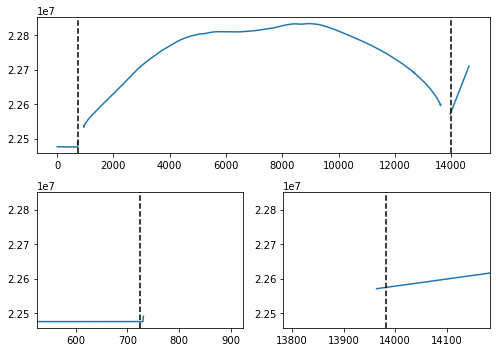

In [216]:
# Here we loop over each profile
i = 20
#C[i,0] += -30
C[i,1] += 30
plot_bounds(i, C, 200)

In [217]:
np.save(folder+"Clean/bounds_C.npy", C)


## 2. Leveling the profiles

This is the slowest part, since it involves looking at 3 consecutive profiles, and correcting for height displacements. For *most* of the timelapse, you should aim to have the <span style="color:#FF7F0E">**current**</span> profile between the <span style="color:#1F77B4">**past** </span> and <span style="color:#2CA02C">**future**</span> ones.
While some particular timepoints are off just because of small miscalculations in finding the edges, more prevalent issues may arise when the actual biofilm-lb border goes out of focus in either the in or out of plane direction. This will lead to a few consecutive offsets in the same side of the sample.


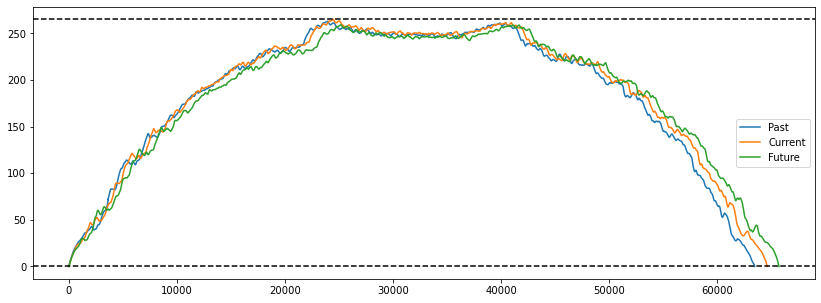

In [596]:
##
i = 69
#offsets[0,1] += 0.5
offsets[i,0] += 0.0
offsets[i,1] += 0.0
plotrel_profile(i, C, offsets)
#plt.ylim(170, 200)

In [218]:
np.save(folder+"Clean/offsets_C.npy", offsets)
np.save(folder+"Clean/bounds_C.npy", C)


## 3. Displacement alignment

Now we have a set of profile heights that correspond to the same timelapse. Since we work using the center of the colonies, it would be useful to have everything aligned, so we can get the data quickly.

Of course, the size of the first inoculum is much less than the final point. For this, we center everything into a 2D array with ALL the timelapse profiles.

In [219]:
offnames = [folder+"Clean/offsets_A.npy", folder+"Clean/offsets_B.npy", folder+"Clean/offsets_C.npy"]
Cnames = [folder+"Clean/bounds_A.npy", folder+"Clean/bounds_B.npy", folder+"Clean/bounds_C.npy"]
dnames = [folder+"Clean/displacement_A.npy", folder+"Clean/displacement_B.npy", folder+"Clean/displacement_C.npy"]


# For timelapses
j = 2                                          # Which of the replicates we'll be working on
offsets = np.load(offnames[j])
C = np.load(Cnames[j]).astype(int)
data = []                                 # We'll do a naive detection of the edges
for i in range(n):
    s = getcleansurf(get_data(files_split[j][i])[0])# Load profiles as a 1-D array
    s_curr = subline(s[C[i,0]:C[i,1]]/1e3, offsets[i,0], offsets[i,1]) # Use edges and offsets to subtract
    data.append(s_curr)

/tmp/ipykernel_9136/2109317321.py:70: RuntimeWarning: divide by zero encountered in true_divide
  f = suma/counts
/tmp/ipykernel_9136/2109317321.py:70: RuntimeWarning: invalid value encountered in true_divide
  f = suma/counts


In [220]:
S = np.array([len(x) for x in data])
np.max(S)

13761

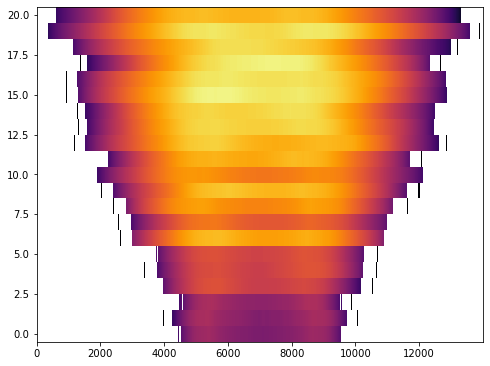

In [222]:
L = 14000
IMG = np.zeros([len(data), L])
IMG[:] = np.nan

start = (L-S)/2
start = start.astype(int)
#shift(47, 25)
#shift(80, 70)
#shift(90, 40)
#start[64] += 1200
#start[65] += 2600
#start[66] += 2600

for i in range(len(data)):
    IMG[i, start[i]:len(data[i])+start[i]] = data[i]
plt.figure(figsize=(8,8))
plt.imshow(IMG, aspect=500, clim=(0, 350), origin="lower", cmap="inferno", interpolation="none")

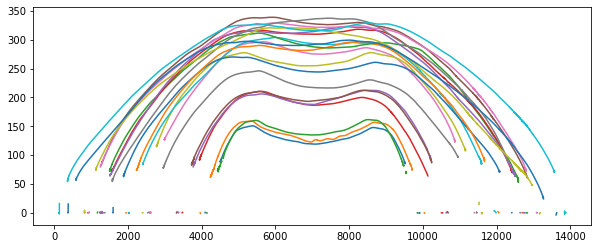

In [223]:
k = 0
k_sp = 21
plt.figure(figsize=(10, 4))
plt.plot(np.transpose(IMG[k:k+k_sp,:]));

In [224]:
np.save(folder+"Clean/bounds_C.npy", C)
np.save(folder+"Clean/offsets_C.npy", offsets)
np.save(folder+"Clean/profiles_C.npy", IMG)
np.save(folder+"Clean/displacement_C.npy", start)

## 4. Save everything into a .csv

Now we have all the required building blocks for our .csv, for each of [A, B, C, control]:
1. Profiles
2. Boundaries
3. Offset
4. Displacement

Now we load everything into a simple panda dataframe, and export it as .csv!

In [4]:
import pandas as pd
df = pd.DataFrame({'file':[], 'replicate':[], 'time':[], 'border_l':[], 'border_r':[], 'offset_l':[], 'offset_r':[], 'displacement':[]})
offnames = [folder+"Clean/offsets_A.npy", folder+"Clean/offsets_B.npy", folder+"Clean/offsets_C.npy"]
Cnames = [folder+"Clean/bounds_A.npy", folder+"Clean/bounds_B.npy", folder+"Clean/bounds_C.npy"]
dnames = [folder+"Clean/displacement_A.npy", folder+"Clean/displacement_B.npy", folder+"Clean/displacement_C.npy"]

replicate = ["A", "B", "C"]
times = np.load(folder+"Clean/times.npy")

In [6]:
# Loop over ABC
for j in range(3):
    offsets = np.load(offnames[j])
    C = np.load(Cnames[j])
    displ = np.load(dnames[j])
    t = times[j,:]
    repl = np.repeat(replicate[j], len(t))
    fnames = [name[len(folder)+4:] for name in files_split[j]]
    b_l, b_r = C[:,0], C[:,1]
    o_l, o_r = offsets[:,0], offsets[:,1]
    tf = pd.DataFrame({'file':fnames, 'replicate':repl, 'time':t, 'border_l':b_l, 'border_r':b_r, 'offset_l':o_l, 'offset_r':o_r, 'displacement':displ})
    df = df.append(tf)
df.to_csv(folder+"Clean/cleaning.csv", index=False) 


In [119]:
times

array([[ 41.24444444,  41.28944444,  41.33722222,  85.21277778,
         85.27      ,  85.38833333, 133.05388889, 133.12833333,
        133.20722222, 184.11777778, 184.18888889, 184.26722222,
        229.25888889, 229.35222222, 229.45      , 277.22722222,
        277.32722222, 277.44111111, 324.81666667, 324.95166667,
        325.05833333],
       [ 41.57277778,  41.61111111,  41.66722222,  85.84444444,
         85.93888889,  86.03888889, 133.66277778, 133.79666667,
        133.94333333, 184.71222222, 184.86666667, 185.02555556,
        229.93444444, 230.10388889, 230.27444444, 277.87222222,
        278.03111111, 278.32444444, 325.96333333, 326.305     ,
        326.70777778],
       [ 41.40722222,  41.45166667,  41.49055556,  85.47777778,
         85.61166667,  85.67111111, 133.34944444, 133.40555556,
        133.465     , 184.38166667, 184.45833333, 184.53      ,
        229.57      , 229.64722222, 229.71888889, 277.55666667,
        277.63      , 277.70277778, 325.21055556, 325.3283